In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
csv_paths = [
    r"C:\Users\Ibon\PycharmProjects\Microgrid\objective2_data_cleaned\Cocoa_aSiMicro03036.csv",
    r"C:\Users\Ibon\PycharmProjects\Microgrid\objective2_data_cleaned\Eugene_CIGS8-001.csv",
    r"C:\Users\Ibon\PycharmProjects\Microgrid\objective2_data_cleaned\Golden_mSi0251.csv"
]

# 📥 Cargar múltiples CSVs y concatenarlos
dfs = [pd.read_csv(path, parse_dates=["Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss"]) for path in csv_paths]
df = pd.concat(dfs, ignore_index=True)

# 🔍 Separar features y target
df = df.drop(columns='Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss')
X = df.drop(columns=['Pmp (W)']).values.astype(np.float32)
y = df['Pmp (W)'].values.astype(np.float32)

# ⚙️ Escalar
scaler = StandardScaler()
X = scaler.fit_transform(X).astype(np.float32)

# 🔀 Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📦 Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train).unsqueeze(1)  # Para que sea shape (N, 1)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test).unsqueeze(1)


In [4]:
# 🔵 Modelo simple
class SimpleDNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleDNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

# 📐 Crear modelo
input_dim = X_train.shape[1]
model = SimpleDNN(input_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SimpleDNN(
  (model): Sequential(
    (0): Linear(in_features=9, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=32, bias=True)
    (11): ReLU()
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)

C:\Users\Ibon\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/150], Loss: 365.1066
Epoch [2/150], Loss: 44.2624
Epoch [3/150], Loss: 40.0149
Epoch [4/150], Loss: 35.9822
Epoch [5/150], Loss: 35.8298
Epoch [6/150], Loss: 33.8795
Epoch [7/150], Loss: 33.5112
Epoch [8/150], Loss: 33.0214
Epoch [9/150], Loss: 30.9987
Epoch [10/150], Loss: 31.9489
Epoch [11/150], Loss: 29.8588
Epoch [12/150], Loss: 29.3411
Epoch [13/150], Loss: 28.7095
Epoch [14/150], Loss: 28.6544
Epoch [15/150], Loss: 27.9066
Epoch [16/150], Loss: 22.3278
Epoch [17/150], Loss: 21.0412
Epoch [18/150], Loss: 19.4281
Epoch [19/150], Loss: 19.2142
Epoch [20/150], Loss: 18.2048
Epoch [21/150], Loss: 17.2167
Epoch [22/150], Loss: 17.9433
Epoch [23/150], Loss: 16.9032
Epoch [24/150], Loss: 16.5957
Epoch [25/150], Loss: 16.2155
Epoch [26/150], Loss: 15.6580
Epoch [27/150], Loss: 15.3491
Epoch [28/150], Loss: 14.7476
Epoch [29/150], Loss: 15.7681
Epoch [30/150], Loss: 15.5446
Epoch [31/150], Loss: 14.4756
Epoch [32/150], Loss: 14.3254
Epoch [33/150], Loss: 13.7117
Epoch [34/150], Lo

C:\Users\Ibon\AppData\Local\Temp\ipykernel_18200\2804488082.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_threediffcsv.pt

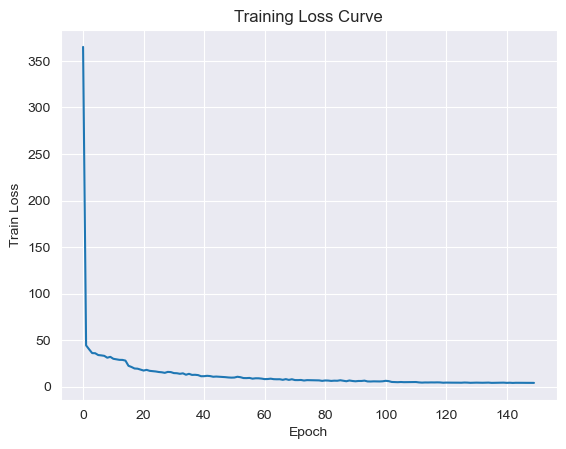

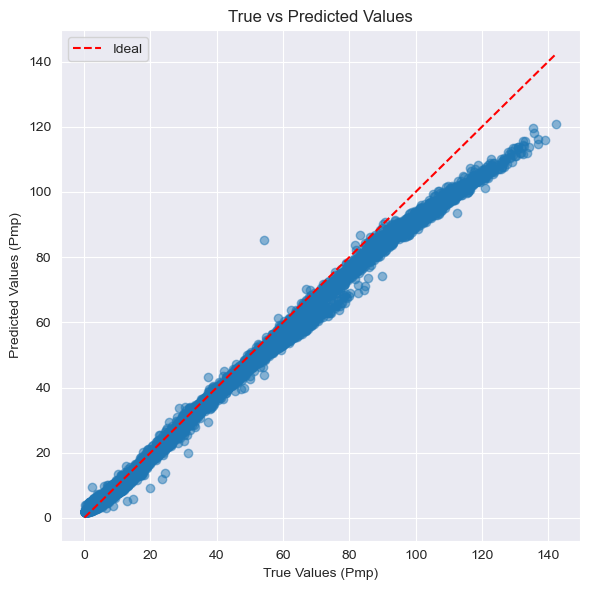

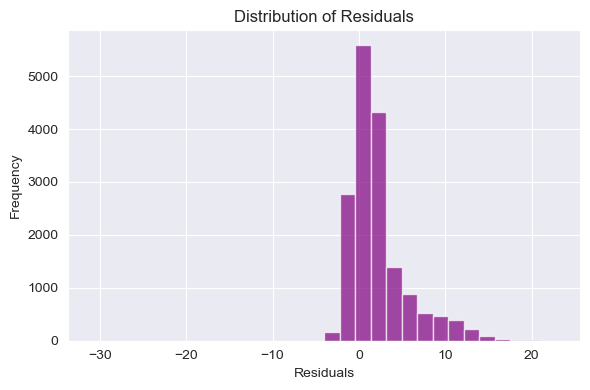

In [5]:
batch_size = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)
criterion = nn.MSELoss()

epochs = 150
best_loss = np.inf
patience = 10
counter = 0
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    
    avg_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    
    scheduler.step(avg_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
        torch.save(model.state_dict(), "best_model_threediffcsv.pth")
    else:
        counter += 1
        if counter >= patience:
            print(f"⏹️ Early stopping at epoch {epoch+1}")
            break

# Cargar mejor modelo
model.load_state_dict(torch.load("best_model_threediffcsv.pth"))

# Evaluación
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor.to(device)).cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    mse = mean_squared_error(y_test_np, y_pred)
    mae = mean_absolute_error(y_test_np, y_pred)
    r2 = r2_score(y_test_np, y_pred)
    
    print(f"\n📊 Test MSE: {mse:.4f}")
    print(f"📏 Test MAE: {mae:.4f}")
    print(f"📈 Test R2: {r2:.4f}")
    
    residuals = y_test_np - y_pred

# 📈 Gráfica de la pérdida
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

# 📈 Scatter plot: Predicciones vs Reales
plt.figure(figsize=(6,6))
plt.scatter(y_test_np, y_pred, alpha=0.5)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--', label='Ideal')
plt.xlabel("True Values (Pmp)")
plt.ylabel("Predicted Values (Pmp)")
plt.title("True vs Predicted Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📉 Histograma de residuos
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, alpha=0.7, color='purple')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()